## Imports

In [41]:
import os 
import glob
import time
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers.convolutional import UpSampling2D, Conv2D
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

## Data preparation

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
print('Max pixel:', train_x.max())
print('Min pixel:', train_x.min())

Max pixel: 255
Min pixel: 0


In [4]:
# 이미지를 [-1, 1] 로 정규화하기 위한 작업
train_x = (train_x - 127.5) / 127.5 

print('Max pixel:', train_x.max())
print('Min pixel:', train_x.min())

Max pixel: 1.0
Min pixel: -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

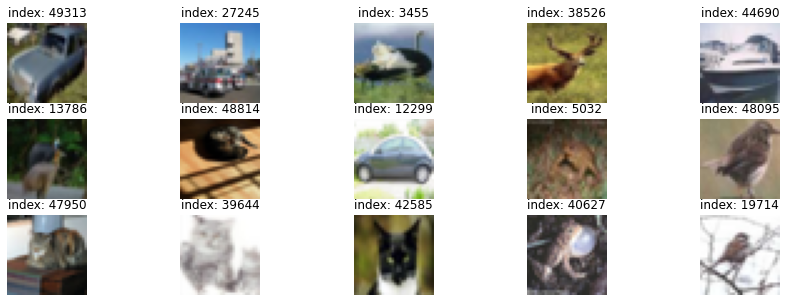

In [6]:
plt.figure(figsize=(15, 5))

for i in range(15):
    plt.subplot(3, 5, i+1)
    random_index = np.random.randint(1, 50000)
    #plt.imshow((train_x[random_index] + 1)/2)
    plt.imshow((train_x[random_index]*127.5 + 127.5).astype('int16'))
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

## Generative model

In [7]:
def make_generator_model_one():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

In [8]:
generator_one = make_generator_model_one()

generator_one.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [9]:
# 노이즈를 생성합니다.
noise = tf.random.normal([1, 100])
generated_image = generator_one(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

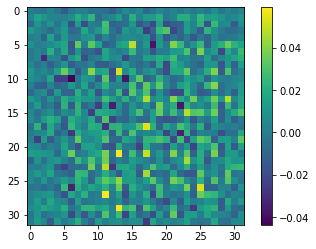

In [10]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## Discriminative model

In [11]:
def make_discriminator_model_one():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1))
    
    return model 

In [12]:
discriminator_one = make_discriminator_model_one()

discriminator_one.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

## Loss function and optimizer

### Loss function

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### Optimizer

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## Training

In [19]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [21]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator_one(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator_one(images, training=True)
        fake_output = discriminator_one(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_one.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_one.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_one.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_one.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [22]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(np.array(predictions[i] * 127.5 + 127.5).astype('uint8'))
        plt.axis('off')
        
    plt.savefig(os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    
    plt.show()

In [23]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6 # matlab 차트의 기본 크기를 15, 6 으로 지정

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.xlabel('batch iters')
    plt.ylabel('accuracy')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    # training_history 디렉토리에 epoch 별로 그래프를 이미지 파일로 저장
    plt.savefig(os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'.format(epoch))
    
    plt.show()

In [24]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_one,
                                 discriminator=discriminator_one)

## Test

In [25]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator_one, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator_one, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [26]:
save_every = 5
EPOCHS = 100

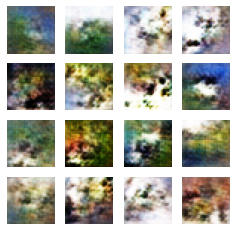

Time for training : 1520 sec


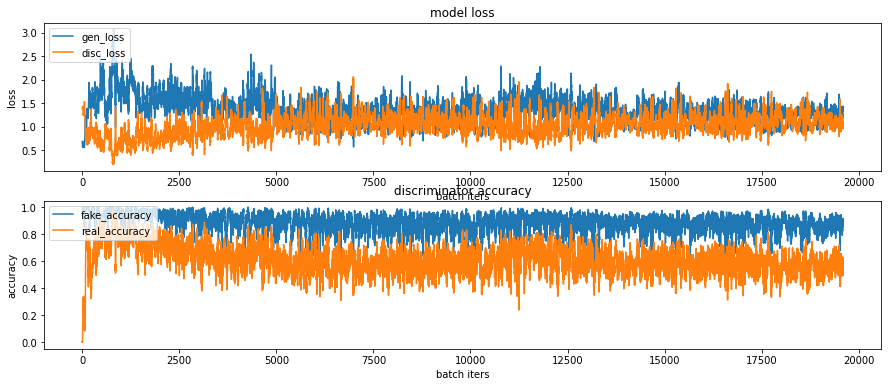

CPU times: user 26min 11s, sys: 2min 41s, total: 28min 52s
Wall time: 25min 21s


In [27]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

In [33]:
dcgan_gif_path = os.getenv('HOME')+'/aiffel/AIFFEL/image/cifar10_dcgan.gif'
    
with imageio.get_writer(dcgan_gif_path, mode='I') as writer:
    filenames = glob.glob(os.getenv('HOME') + '/aiffel/image/cifar10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [34]:
dcgan_loac_gif_path = os.getenv('HOME')+'/aiffel/AIFFEL/image/cifar10_loss_accuracy.gif'

# training_history 디렉토리에 epoch 별로 그래프를 이미지 파일로 저장
plt.savefig(os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png')
    
    
with imageio.get_writer(dcgan_loac_gif_path, mode='I') as writer:
    filenames = glob.glob(os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/training_history/train_history_*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<Figure size 1080x432 with 0 Axes>

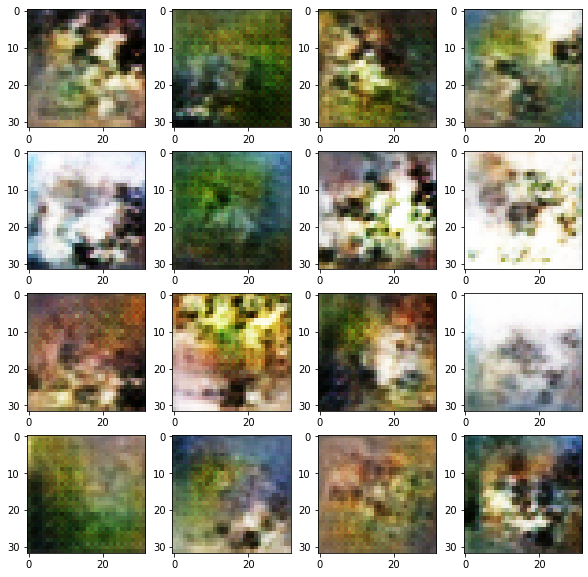

In [35]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([16, 100])
generated_image = generator(noise, training=False)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    np_generated = generated_image[i].numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated)
plt.show()

| **DCGAN** | **Loss and Accuracy** |
| --- | --- |
| ![image1](./image/cifar10_dcgan.gif) | ![image2](./image/cifar10_loss_accuracy.gif) |

# Refine version

In [36]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss*0.4
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### Optimizer

generator_optimizer = tf.keras.optimizers.Adam(5e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-5)

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

## Training

BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator_one(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator_one(images, training=True)
        fake_output = discriminator_one(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_one.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_one.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_one.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_one.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(np.array(predictions[i] * 127.5 + 127.5).astype('uint8'))
        plt.axis('off')
        
    plt.savefig(os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/generated_samples/sample2_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    
    plt.show()

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6 # matlab 차트의 기본 크기를 15, 6 으로 지정

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.xlabel('batch iters')
    plt.ylabel('accuracy')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    # training_history 디렉토리에 epoch 별로 그래프를 이미지 파일로 저장
    plt.savefig(os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/training_history/train_history2_{:04d}.png'.format(epoch))
    
    plt.show()

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints2'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_one,
                                 discriminator=discriminator_one)

## Test

def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator_one, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator_one, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

save_every = 5
EPOCHS = 200

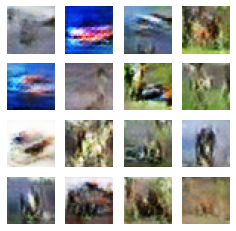

Time for training : 3130 sec


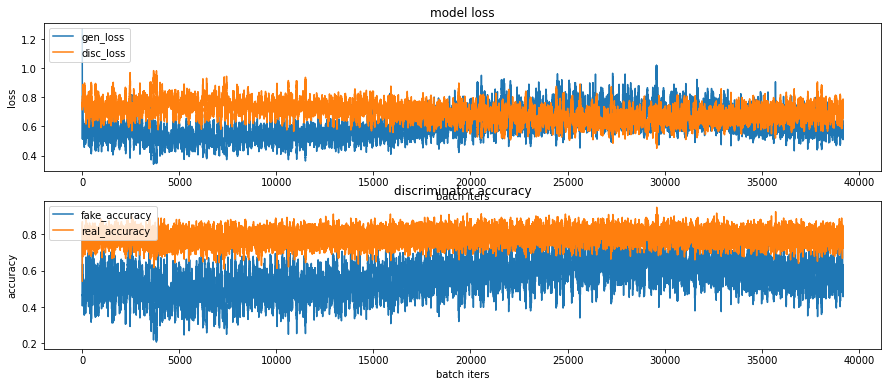

CPU times: user 53min 37s, sys: 5min 17s, total: 58min 54s
Wall time: 52min 13s


In [37]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

In [38]:
dcgan_refine_gif_path = os.getenv('HOME')+'/aiffel/AIFFEL/image/cifar10_dcgan_refine.gif'
    
with imageio.get_writer(dcgan_refine_gif_path, mode='I') as writer:
    filenames = glob.glob(os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/generated_samples/sample2*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [39]:
dcgan_refine_loac_gif_path = os.getenv('HOME')+'/aiffel/AIFFEL/image/cifar10_loss_accuracy_refine.gif'

# training_history 디렉토리에 epoch 별로 그래프를 이미지 파일로 저장
plt.savefig(os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/training_history/train_history2_{:04d}.png')
    
    
with imageio.get_writer(dcgan_refine_loac_gif_path, mode='I') as writer:
    filenames = glob.glob(os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/training_history/train_history2_*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<Figure size 1080x432 with 0 Axes>

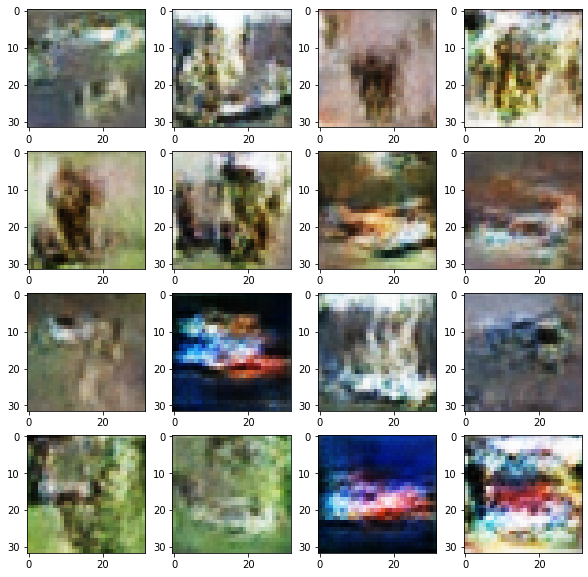

In [40]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints2'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([16, 100])
generated_image = generator(noise, training=False)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    np_generated = generated_image[i].numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated)
plt.show()

| **DCGAN_refine** | **Loss and Accuracy** |
| --- | --- |
| ![image5](./image/cifar10_dcgan_refine.gif) | ![image6](./image/cifar10_loss_accuracy_refine.gif) |

## Discussion

1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였는가.
 - **오브젝트의 유무를 이미지로 확인했다.**  
2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였는가.
 - **gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.**  
3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였는가.
 - **층을 증가시켜서 모델구조를 변경해보았을 때 그래프의 추세가 크게 변하지 않았었기에, 학습과정에 대하여 개선을 시도하였다.**  
 - **Fake image보다 real image를 더 잘 구별할 수 있도록, fake loss에 0.4의 패널티를 주었고, epoch를 200으로 증가시키고, learning rate를 5e-5로 변경했다.**  
 - **Real image에 대한 accuracy가 fake image의 accuracy보다 높아지도록 학습 모델이 개선되었으며, 제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.**  

| **Original model** | **Refine model** |
| --- | --- |
|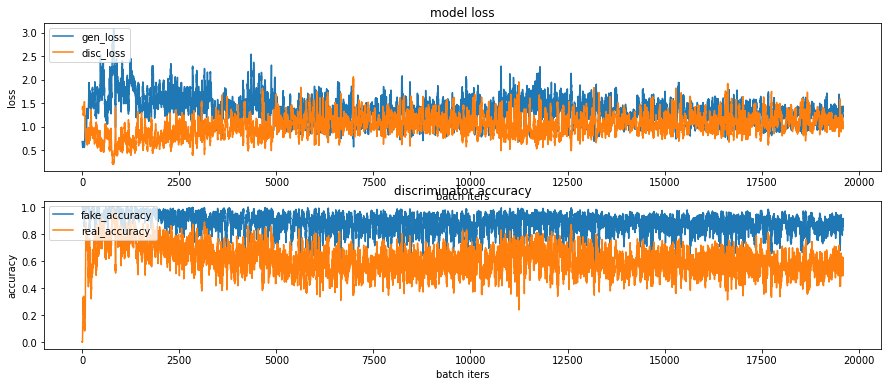 | 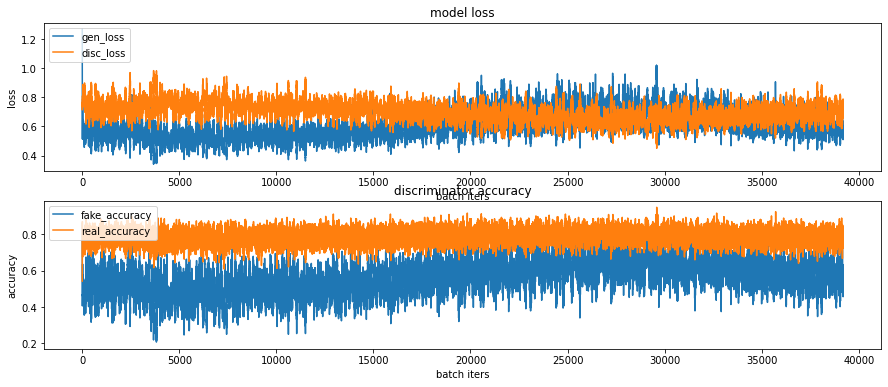 |

## Reference

1. https://github.com/SunCreation/aiffel/blob/main/Working/AI/Style_Generator/%5BEX-13%5D.ipynb
2. https://zzcojoa.tistory.com/88?category=1035878